In [1]:
! pip install ptflops

  Preparing metadata (setup.py) ... done
  Created wheel for ptflops: filename=ptflops-0.6.9-py3-none-any.whl size=11712 sha256=f34ced83e80372e00b563e0dd3fc246f71c6a69c5e2c1a8ba3e7fb5be9e0ed45
  Stored in directory: /root/.cache/pip/wheels/dc/c3/88/c5d0307c4ad1e8a9d0050921ed2d57e640062d9fb62780e40e
Successfully built ptflops


In [2]:
! pip install torchsummary

In [3]:
import torch
import torchvision
from torch import nn
from torchvision import transforms
import torch.optim as optim
from torchsummary import summary
from ptflops import get_model_complexity_info
import matplotlib.pyplot as plt
import numpy as np
from torch.nn import functional as F

In [4]:
# Define how we want images transformed
resize = (64, 64)
trans = transforms.Compose([transforms.Resize(resize),
                            transforms.ToTensor()])

# Create training and validation sets
training_set = torchvision.datasets.CIFAR10('./data', train=True, 
                                                 transform=trans, download=True)
validation_set = torchvision.datasets.CIFAR10('./data', train=False, 
                                                   transform=trans, download=True)

# Create dataloaders for each set
training_loader = torch.utils.data.DataLoader(training_set, batch_size=128, 
                                              shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=128, 
                                                shuffle=False, num_workers=2)


print("Training set size:", len(training_set))
print("Validation set size:", len(validation_set))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Training set size: 50000
Validation set size: 10000


In [5]:
# Define the training loop for each epoch
def trainLoop(dataloader, model, loss_fn, optimizer):

    numBatches = len(dataloader)
    dataSize = len(dataloader.dataset)
    totalLoss = 0
    numCorrect = 0

    for batch, (X, y) in enumerate(dataloader):
    
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        totalLoss = totalLoss + loss.item()

        if batch % 100 == 0:
            loss = loss.item()
            interLosses.append(loss)
            avgLoss = totalLoss / (batch + 1)
            avgLosses.append(avgLoss) 
            print("loss:", loss)

        pred = model(X)
        numCorrect = numCorrect + (pred.argmax(1) == y).type(torch.float).sum().item()
    
    trainAcc = numCorrect / dataSize
    trainHist.append(trainAcc)
    trainAccPercent = trainAcc * 100
    
    epochLoss = totalLoss / len(dataloader)
    trainLosses.append(epochLoss)

    print("Training Accuracy: ", trainAccPercent,  "    Training Loss: ", epochLoss)

In [6]:
# Define the validation loop for each epoch
def valLoop(dataloader, model, loss_fn):
    
    numBatches = len(dataloader)
    dataSize = len(dataloader.dataset)
    valLoss = 0
    numCorrect = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            valLoss = valLoss + loss_fn(pred, y).item() 
            numCorrect = numCorrect + (pred.argmax(1) == y).type(torch.float).sum().item()

    
    valAcc = numCorrect / dataSize
    valHist.append(valAcc)
    valAccPercent = valAcc * 100

    avgLoss = valLoss / numBatches
    valLosses.append(avgLoss)
    
    print("Validation Accuracy:", valAccPercent, "    Validation Loss: ", avgLoss)
    print(" ")

# 3b) Baseline ResNet-26

In [8]:
class Residual(nn.Module): 

    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [9]:
def ResBlock(num_residuals, num_channels, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels))
    
    return nn.Sequential(*blk)

In [10]:
def body(arch):
    bodyBlocks = []
    for i, b in enumerate(arch):
        bodyBlocks.append(ResBlock(*b, first_block=(i==0)))
    
    return nn.Sequential(*bodyBlocks)

In [11]:
res26BigBlock1 = nn.Sequential(
                 nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
                 nn.LazyBatchNorm2d(), nn.ReLU(),
                 nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [12]:
res26BigBlock2 = body(((2, 64), (3, 128), (4, 256), (2, 512)))

In [13]:
res26BigBlock3 = nn.Sequential(
                 nn.AdaptiveAvgPool2d((1, 1)), 
                 nn.Flatten(),
                 nn.LazyLinear(10))

In [15]:
ResNet26 = nn.Sequential(
    res26BigBlock1,
    res26BigBlock2,
    res26BigBlock3
)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ResNet26.parameters(), lr=0.01)

In [17]:
# Begin training over 10 epochs
epochs = 10
valHist = []
valLosses = []
trainHist = []
trainLosses = []
interLosses = []
avgLosses = []

for t in range(epochs):
    actualEpoch = t+1
    print("Epoch", actualEpoch)
    trainLoop(training_loader, ResNet26, criterion, optimizer)
    valLoop(validation_loader, ResNet26, criterion)

Epoch 1
loss: 2.6095545291900635
loss: 1.6628185510635376
loss: 1.4992895126342773
loss: 1.2709031105041504
Training Accuracy:  79.826     Training Loss:  1.4018198489533056
Validation Accuracy: 58.540000000000006     Validation Loss:  1.1572939481916307
 
Epoch 2
loss: 1.0884041786193848
loss: 0.950547993183136
loss: 0.9477829933166504
loss: 0.877978503704071
Training Accuracy:  90.216     Training Loss:  1.0002672111286837
Validation Accuracy: 64.22     Validation Loss:  1.0259336987628211
 
Epoch 3
loss: 0.8141418099403381
loss: 0.7442638874053955
loss: 0.8055928945541382
loss: 0.7401645183563232
Training Accuracy:  96.138     Training Loss:  0.7860760947932368
Validation Accuracy: 69.16     Validation Loss:  0.8781375832195524
 
Epoch 4
loss: 0.6899192333221436
loss: 0.640373945236206
loss: 0.5393899083137512
loss: 0.6331935524940491
Training Accuracy:  98.688     Training Loss:  0.6197293177437599
Validation Accuracy: 68.83     Validation Loss:  0.9237254850472076
 
Epoch 5
loss: 

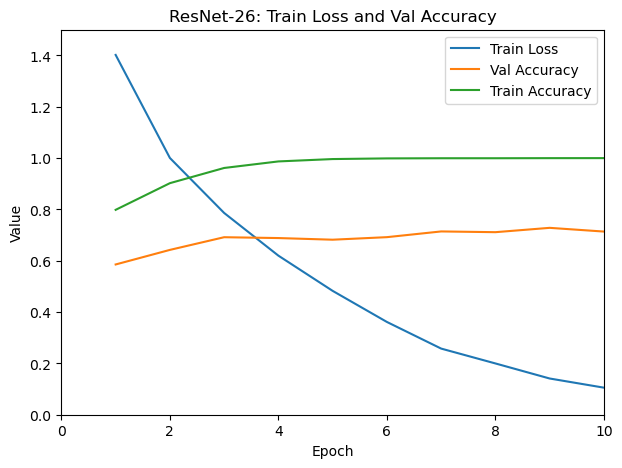

In [18]:
# Plot results
x = np.linspace(1, epochs, epochs)     
plt.figure(figsize=(7,5))
plt.title("ResNet-26: Train Loss and Val Accuracy")
plt.plot(x, trainLosses, label="Train Loss")
plt.plot(x, valHist, label="Val Accuracy")
plt.plot(x, trainHist, label="Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.xlim(0, epochs)
plt.ylim(0, 1.5)
plt.show()

### Train time: ~150ish minutes for 10 epochs w/ P100 GPU

In [19]:
macs, params = get_model_complexity_info(ResNet26, (3, 64, 64), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
print('Computational complexity: ', macs)
print('Number of parameters: ', params)

Sequential(
  13.84 M, 100.000% Params, 205.49 MMac, 100.000% MACs, 
  (0): Sequential(
    9.6 k, 0.069% Params, 9.96 MMac, 4.848% MACs, 
    (0): Conv2d(9.47 k, 0.068% Params, 9.7 MMac, 4.720% MACs, 3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(128, 0.001% Params, 131.07 KMac, 0.064% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(0, 0.000% Params, 65.54 KMac, 0.032% MACs, )
    (3): MaxPool2d(0, 0.000% Params, 65.54 KMac, 0.032% MACs, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    13.83 M, 99.894% Params, 195.52 MMac, 95.149% MACs, 
    (0): Sequential(
      148.22 k, 1.071% Params, 37.95 MMac, 18.466% MACs, 
      (0): Residual(
        74.11 k, 0.535% Params, 18.97 MMac, 9.233% MACs, 
        (conv1): Conv2d(36.93 k, 0.267% Params, 9.45 MMac, 4.601% MACs, 64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(36.93 k, 0.267% Params, 9.4